In [1]:
### Script for using MOFA factors as predictors

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [3]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [4]:
data_path = '../data/current'

In [5]:
result_path = '../results/current'

In [6]:
data_path

[1] "../data/current"

In [7]:
### Data to load for Factors and Gene Expression

version = 'V_FINAL_INTEGRATED_FALSE'

# Load Data

## Sample Data

In [10]:
## Load sample meta-data

In [9]:
path = paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv')
sample_data = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-12-10 11:16:00 CET"


In [11]:
#patients_filter = unique(sample_data$sample_id[is.na(str_extract(sample_data$sample_id, 'k'))])  # use only acs samples
patients_filter = unique(sample_data$sample_id) #  use all samples

In [12]:
# Add new columns for later prediction

In [13]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [14]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [15]:
## Concatenate outcome with class

In [16]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [17]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

In [19]:
## overview amount samples per outome + TP
sample_data %>% group_by(tp_outcome) %>% count()

tp_outcome,n
<chr>,<int>
TP0_NA,34
TP1_NA,7
TP1_bad,7
TP1_good,15
TP2_NA,7
TP2_bad,8
TP2_good,14
TP3_NA,7
TP3_bad,7


## Factor Data to use

In [21]:
path = paste0(result_path, '/E-Analysis/Factor_Data_', version, '.csv')
factor_data = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:34:39 CET"


In [22]:
head(factor_data,4)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.4811325,-0.2731317,1.4988169,-0.4135678,1.5052706,-0.92308998,-0.3904185,-0.1944797,0.16486799,-0.558130047,⋯,1.371875754,0.18829559,-0.30821631,-0.47997108,0.34688969,0.56926106,0.416665730,-0.60204874,-0.03085489,k1
2,0.8920603,-0.7547770,0.3501023,-0.1524478,0.4074517,-0.04596939,0.6276925,-1.1656937,-0.05003504,-0.338034341,⋯,-0.102028456,0.11991185,0.20967181,0.09246619,0.13351102,-0.04905520,-0.001722867,0.07838055,-0.03818913,k10
3,-1.2439808,-0.9826224,-0.8230479,-0.3559941,1.0458397,0.11800347,-0.2770340,-0.1901323,-0.10959612,-0.479903608,⋯,-0.015925683,-0.04062541,0.04315219,-0.02329634,-0.02298920,0.03253449,0.177102131,0.11100223,-0.02994567,k11
4,-1.9847781,-1.6711527,-1.0857874,-0.4570102,0.6403206,-0.37214375,-0.9344379,-0.1916442,0.03676072,-0.004778085,⋯,0.001169425,0.03116989,0.14784586,0.48202979,0.01680141,0.01807012,0.288699222,-0.15412217,-0.10906315,k12


## Grace Score

In [23]:
path = paste0(data_path, '/preprocessed-data/meta-data/Grace_Score_processed.csv')
grace_score = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 16:05:21 CET"


In [24]:
grace_score$sample_id = paste0('m', str_replace(grace_score$sample_id, '.*_', ''), '.1')

In [25]:
head(grace_score,2)

,sample_id,Troponin_TP1,Grace_Score
,<chr>,<dbl>,<chr>
1,m1.1,0.687,
2,m10.1,24.900,104


## Normalized Gene Expression Data

In [26]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',str_replace(version, '_FALSE', ''),'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:26:41 CET"


In [27]:
data_long$X = NULL

# Prepare data for prediction

In [28]:
### Merge the potential different features for prediction

In [30]:
## Add factor data to sample_data

In [31]:
data = merge(factor_data, unique(sample_data[,c('sample_id', 'classification', 'measurement', 'delta_ef_value_class', 'delta_ef_value_class_summarized', 'tp_outcome', 'CK', 'CK_MB', 'Troponin', 'CRP')]), by.x = 'sample_id', by.y = 'sample_id')

In [32]:
## Add grace score

In [33]:
data = merge(data, grace_score, all.x = TRUE)

In [34]:
## Add normalized gene expression values of selected features

In [35]:
unique(data_long$variable[!is.na(str_extract(data_long$variable, 'CD53'))])

[1] "X0_T.cell.CD4__CD53"               "X1_T.cell.CD8__CD53"              
 [3] "X10_B.cell__CD53"                  "X11_T.cell.CD4__CD53"             
 [5] "X12_Monocytes...CD16_FCGR3A__CD53" "X3_NK__CD53"                      
 [7] "X4_Monocytes...CD14__CD53"         "X6_Monocytes...CD14__CD53"        
 [9] "X7_Monocytes...CD14__CD53"         "X8_B.cell__CD53"                  
[11] "X9_Monocytes...CD16_FCGR3A__CD53"

In [36]:
features = c('CK', 'CK_MB', 'Troponin', 'CRP', 'X3_NK__TXNIP','X3_NK__PRF1', 'X3_NK__LITAF' , 'X3_NK__GZMB', 'X3_NK__FYN', 'X3_NK__CST7', 'X3_NK__CD53')

In [37]:
gene_expression_data = data_long[data_long$variable %in% features,]

In [38]:
gene_expression_data = gene_expression_data %>% dcast(sample_id ~ variable, value.var = 'value')

In [39]:
colnames(gene_expression_data) = paste0('Normalized_', colnames(gene_expression_data))

In [40]:
nrow(data)

[1] 128

In [41]:
data = merge(data, gene_expression_data, by.x = 'sample_id', by.y = 'Normalized_sample_id')

In [42]:
nrow(data)

[1] 128

# Prediction for Factor 4 at TP1

In [43]:
## convert clinical features to numeric

In [44]:
data$CK = as.numeric(data$CK)
data$Troponin = as.numeric(data$Troponin)
data$CRP = as.numeric(data$CRP)
data$Grace_Score = as.numeric(data$Grace_Score)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [45]:
## select prediction variables

In [46]:
prediction_vars = c( 'Factor4',  'Normalized_CK', 'Normalized_CRP', 'Normalized_Troponin', 'Grace_Score')

In [47]:
## select variable that should be predicted

In [48]:
prediction_group = 'tp_outcome'
prediction_subset = c('TP1_good', 'TP1_bad')

In [49]:
prediction_data = data[,c(prediction_vars, prediction_group)]
prediction_data$y = prediction_data[,prediction_group]
prediction_data = prediction_data[prediction_data$y %in% prediction_subset,]

prediction_data$y[prediction_data$y == prediction_subset[2]] = 1  # predict BAD outcome 
prediction_data$y[prediction_data$y == prediction_subset[1]] = 0  # good outcome as control

In [50]:
## Check in which direction to adjust
prediction_data %>% group_by(tp_outcome,y) %>% summarise(across(everything(), mean, na.rm =TRUE))

# predict bad --> higher values for bad

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(everything(), mean, na.rm = TRUE)`.
ℹ In group 1: `tp_outcome = "TP1_bad"` and `y = "1"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”
`summarise()` has grouped output by 'tp_outcome'. You can override using the
`.groups` argument.


tp_outcome,y,Factor4,Normalized_CK,Normalized_CRP,Normalized_Troponin,Grace_Score
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TP1_bad,1,-1.1259212,0.9443535,-0.6691209,0.7195349,126.0
TP1_good,0,-0.6298132,0.6861117,-0.6469700,0.2787430,100.7


In [51]:
prediction_data %>% group_by(tp_outcome) %>% count()

tp_outcome,n
<chr>,<int>
TP1_bad,6
TP1_good,13


In [52]:
# Adjust sign of factor values (so that bad values are the higher ones)
prediction_data$Factor4 = -1*prediction_data$Factor4
prediction_data$Normalized_CRP = -1* prediction_data$Normalized_CRP

In [53]:
# Transform and scale scores of prediction variables (to be between 0 and 1)

In [54]:
prediction_data = cbind( prediction_data[,c('y', prediction_group)],
      apply(prediction_data[,prediction_vars], MARGIN = 2, FUN = function(x){
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))}))

In [55]:
## Transform to long format

In [56]:
prediction_data_long = melt(prediction_data)

Using y, tp_outcome as id variables



In [57]:
# remove NA values

In [58]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [60]:
## get amount observations per prediction group

In [61]:
amount_samples = prediction_data_long %>% group_by(variable) %>% count()

In [62]:
prediction_data_long = merge(prediction_data_long, amount_samples)

In [63]:
prediction_data_long$variable_w_n = paste0(prediction_data_long$variable, ' (n=', prediction_data_long$n, ')')

In [64]:
head(prediction_data_long,2)

,variable,y,tp_outcome,value,n,variable_w_n
,<fct>,<chr>,<chr>,<dbl>,<int>,<chr>
1,Factor4,1,TP1_bad,0.4734997,19,Factor4 (n=19)
2,Factor4,1,TP1_bad,0.8558891,19,Factor4 (n=19)


## Calculate AUC values

In [68]:
auc_values = data.frame()

In [69]:
for(i in unique(prediction_data_long$variable)){
    calc_auc = data.frame(variable = i, 
                          auc = auc(prediction_data_long$y[prediction_data_long$variable == i], prediction_data_long$value[prediction_data_long$variable == i])
                          )
    auc_values = rbind(auc_values, calc_auc)
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [70]:
auc_values

variable,auc
<chr>,<auc>
Factor4,0.8333333
Grace_Score,0.7333333
Normalized_CK,0.6025641
Normalized_CRP,0.5181818
Normalized_Troponin,0.6666667


In [71]:
### Save AUC values

In [72]:
write.csv(auc_values, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_ROC_Plot_AUC_values.csv'), row.names = FALSE)

In [73]:
auc(prediction_data_long$y[prediction_data_long$variable == 'Factor4'], prediction_data_long$value[prediction_data_long$variable == 'Factor4'])

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8333

## Plot prediction / ROC

In [74]:
# Figure Name
figure_name = 'FIG10_E9_ROC_Factor4_TP1'

In [75]:
# Sizes of the plot
width_par = 2
height_par = 2

In [76]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity')

In [77]:
## Specify Plot
rocplot = ggplot(prediction_data_long, aes(m = value, d = as.numeric(y), color = variable_w_n, linetype= variable_w_n))+ geom_roc(n.cuts=0,labels=FALSE, size = 0.5)

In [78]:
unique(prediction_data_long$variable_w_n)

[1] "Factor4 (n=19)"             "Grace_Score (n=16)"        
[3] "Normalized_CK (n=19)"       "Normalized_CRP (n=16)"     
[5] "Normalized_Troponin (n=19)"

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


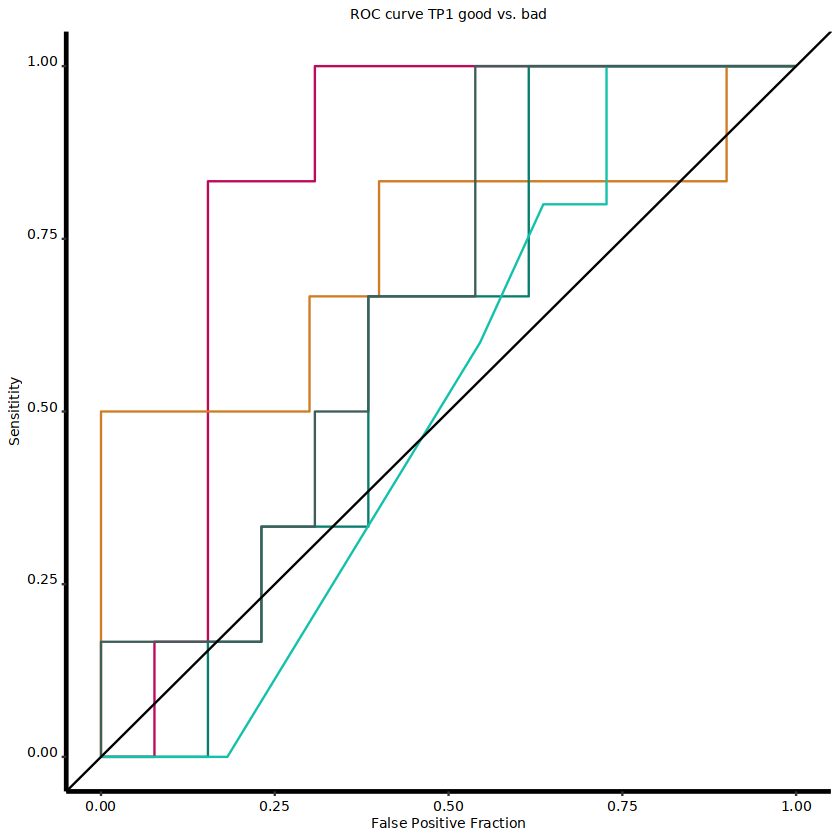

In [79]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle + 
    ggtitle('ROC curve TP1 good vs. bad') +
    geom_abline(slope = 1, intercept = 0) +     
    scale_color_manual(values = c('Factor1 (n=21)' = "#BC0B58",
                                  'Factor4 (n=19)' = "#BC0B58",
                                  'Normalized_CK (n=19)' = "#087C6D",
                                  'Normalized_CRP (n=16)'="#11C1A9",
                                  'Normalized_Troponin (n=19)'="#3F5E5A",
                                  'Grace_Score (n=16)' = '#CF7C24'
                                 ))+
   scale_linetype_manual(values = c('Factor1 (n=21)' = "dashed",
                                    'Factor4 (n=19)' = "solid",
                                  'Normalized_CK (n=19)' = "solid",
                                  'Normalized_CRP (n=16)'="solid",
                                  'Normalized_Troponin (n=19)'="solid",
                                     'Grace_Score (n=16)' = 'solid'
                                 ))+
    theme(legend.position = 'none')

#legend_roc = get_legend(roc_plot)
    

roc_plot

In [80]:
pdf(paste0('figures/Final_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


png 
  2

In [81]:
color_data = data.frame(description = c('Factor4 (n=19)', 'Normalized_CK (n=19)',  'Normalized_CRP (n=16)',  'Normalized_Troponin (n=19)'),
                        color = c( "#BC0B58","#087C6D","#11C1A9","#3F5E5A"))

In [82]:
# Test calculation of ROC values

# prediction_data[!is.na(prediction_data$Normalized_CRP ),]

In [83]:
### Seperately define legend

In [84]:
legend_add  = Legend(labels = unique(color_data$description), labels_gp = gpar(fontsize = 8),legend_gp =list(col = unique(c(unique(color_data$color)))), 
    nrow = 4, type = 'lines') 

In [85]:
legend_add_vertical = packLegend(legend_add, direction = "horizontal")

In [86]:
pdf(paste0('figures/Final_Figures/ROC_Factor4_Legend_Text', '.pdf'), 
    width =2, 
    height = 0.7)
draw(legend_add_vertical)
dev.off()

png 
  2

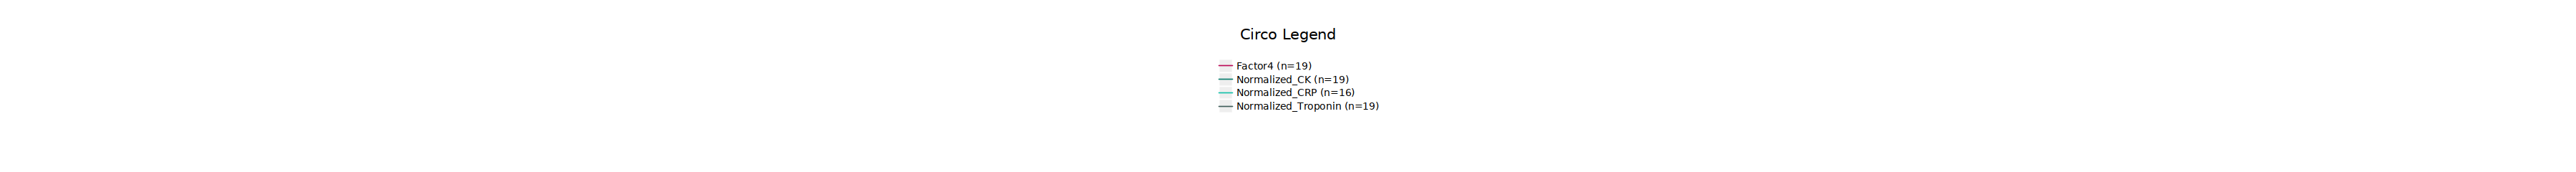

In [87]:
options(repr.plot.width=30, repr.plot.height=2)
draw(legend_add_vertical, test = "Circo Legend")

## Prediction metrics table

In [88]:
head(prediction_data_long,2)

,variable,y,tp_outcome,value,n,variable_w_n
,<fct>,<chr>,<chr>,<dbl>,<int>,<chr>
1,Factor4,1,TP1_bad,0.4734997,19,Factor4 (n=19)
2,Factor4,1,TP1_bad,0.8558891,19,Factor4 (n=19)


In [89]:
prediction_data_long$y = as.factor(prediction_data_long$y)

In [90]:
levels(prediction_data_long$y)

[1] "0" "1"

In [91]:
prediction_data_long$y = relevel(prediction_data_long$y, '0')

In [92]:
TP1_prediction_metrics = data.frame()

In [93]:
for(i in unique(prediction_data_long$variable)){
    data_use = prediction_data_long[prediction_data_long$variable == i,]
    metrics = measureit(score =  data_use$value, class =  data_use$y, measure = c( 'PREC', 'REC', 'SPEC', 'FPR'))
    metrics = data.frame(do.call(cbind, metrics))
    metrics$model = i
    
    TP1_prediction_metrics = rbind( metrics, TP1_prediction_metrics)
    }

In [94]:
head(TP1_prediction_metrics,2)

,Cutoff,Depth,TP,FP,TN,FN,SPEC,PREC,REC,FPR,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Inf,0.00000000,0,0,13,6,1,NaN,0.0000000,0,Normalized_Troponin
2,1,0.05263158,1,0,13,5,1,1,0.1666667,0,Normalized_Troponin


In [95]:
### Save as supplementary table

In [96]:
write.csv(TP1_prediction_metrics, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_prediction_metrics.csv'), row.names = FALSE)

# Prediction Factor 4 TP1 (taking into account other TPs for all variables)

In [186]:
## choose prediction variables

In [187]:
prediction_vars = c('Factor4',  'Normalized_CK', 'Normalized_Troponin',  'Normalized_CRP')

In [188]:
## select variable to predict

In [189]:
prediction_group = 'tp_outcome'
prediction_subset = c('TP1_good', 'TP1_bad')

In [190]:
#colnames(data)

In [191]:
prediction_data = data[,c(prediction_vars, prediction_group, 'sample_id')]
prediction_data$y = prediction_data[,prediction_group]


In [192]:
prediction_data$sample = str_replace(prediction_data$sample_id, '\\..*', '')
prediction_data$TP = str_replace(prediction_data$tp_outcome, '_.*', '')

In [193]:
## Add features to prediction data

In [194]:
add_features = prediction_data %>% group_by(sample) %>% summarise(Mean_CK = mean(Normalized_CK, na.rm = TRUE), Max_CK = max(Normalized_CK, na.rm = TRUE), Mean_Troponin = mean(Normalized_Troponin, na.rm = TRUE), Max_Troponin = max(Normalized_Troponin, na.rm = TRUE), Max_CRP = max(Normalized_CRP, na.rm = TRUE))

Warning message:
“There were 22 warnings in `summarise()`.
The first warning was:
ℹ In argument: `Max_CK = max(Normalized_CK, na.rm = TRUE)`.
ℹ In group 2: `sample = "k10"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 21 remaining warnings.”


In [195]:
head(prediction_data,2)

,Factor4,Normalized_CK,Normalized_Troponin,Normalized_CRP,tp_outcome,sample_id,y,sample,TP
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-0.4135678,-2.397022,-1.286479,-0.3186394,TP0_NA,k1,TP0_NA,k1,TP0
2,-0.1524478,NA,NA,-0.8871466,TP0_NA,k10,TP0_NA,k10,TP0


In [196]:
add_features2 = prediction_data[prediction_data$TP == 'TP2' ,c('sample', 'Normalized_CRP')] ## CRP values at diff TP's
colnames(add_features2) = c('sample', 'Normalized_CRP_TP2')
add_features3 = prediction_data[prediction_data$TP == 'TP3' ,c('sample', 'Normalized_CRP')]
colnames(add_features3) = c('sample', 'Normalized_CRP_TP3')
add_features4 = prediction_data[prediction_data$TP == 'TP1' ,c('sample', 'Normalized_CRP')]
colnames(add_features4) = c('sample', 'Normalized_CRP_TP1')

In [197]:
add_features = merge(add_features, add_features2, all.x = TRUE)
add_features = merge(add_features, add_features3, all.x = TRUE)
add_features = merge(add_features, add_features4, all.x = TRUE)

In [198]:
nrow(add_features)

[1] 62

In [199]:
colnames(add_features)[!colnames(add_features) == 'sample']

[1] "Mean_CK"            "Max_CK"             "Mean_Troponin"     
[4] "Max_Troponin"       "Max_CRP"            "Normalized_CRP_TP2"
[7] "Normalized_CRP_TP3" "Normalized_CRP_TP1"

In [200]:
prediction_data = merge(prediction_data[,c('sample', 'y', 'tp_outcome', 'Factor4')], add_features)

In [201]:
prediction_data = prediction_data[prediction_data$y %in% prediction_subset,]

prediction_data$y[prediction_data$y == prediction_subset[2]] = 1  # predict BAD outcome 
prediction_data$y[prediction_data$y == prediction_subset[1]] = 0  # good outcome as control

In [202]:
# Adjust sign of Factor values
prediction_data$Factor4 = -1*prediction_data$Factor4
prediction_data$Normalized_CRP_TP2 = -1*prediction_data$Normalized_CRP_TP2
prediction_data$Normalized_CRP_TP1 = -1*prediction_data$Normalized_CRP_TP1

In [203]:
# Transform and scale scores of prediction variables (to be between 0 and 1)

In [204]:
prediction_data = cbind( prediction_data[,c('y', prediction_group)],
      apply(prediction_data[,c('Factor4', colnames(add_features)[!colnames(add_features) == 'sample'])], MARGIN = 2, FUN = function(x){
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))}))

In [205]:
head(prediction_data,5)

,y,tp_outcome,Factor4,Mean_CK,Max_CK,Mean_Troponin,Max_Troponin,Max_CRP,Normalized_CRP_TP2,Normalized_CRP_TP3,Normalized_CRP_TP1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,1,TP1_bad,0.4734997,1.0000000,0.7503890,1.0000000,1.0000000,0.9173853,NA,0.9173853,0.2442384
45,1,TP1_bad,0.8558891,0.4562227,0.5261785,0.5556089,0.6342725,0.7232977,0.6955747,0.7232977,0.4182388
49,1,TP1_bad,0.7560452,0.4847296,0.4550662,0.4835328,0.5974694,0.4818991,0.4276187,0.4485679,0.6270265
53,0,TP1_good,1.0000000,0.6155006,0.4283336,0.4316984,0.4713510,0.7119304,0.4926638,0.7119304,0.6270265
60,1,TP1_bad,0.7118677,0.2195981,0.2955057,0.3321533,0.4162823,0.6008172,0.5507717,0.6008172,0.6270265


In [206]:
## Transform to long format

In [207]:
prediction_data_long = melt(prediction_data)

Using y, tp_outcome as id variables



In [208]:
head(prediction_data_long,2)

,y,tp_outcome,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,1,TP1_bad,Factor4,0.4734997
2,1,TP1_bad,Factor4,0.8558891


In [209]:
## remove NA values

In [210]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [211]:
## get amount of samples per prediction group

In [212]:
amount_samples = prediction_data_long %>% group_by(variable) %>% count()

In [213]:
prediction_data_long = merge(prediction_data_long, amount_samples)

In [214]:
prediction_data_long$variable_w_n = paste0(prediction_data_long$variable, ' (n=', prediction_data_long$n, ')')

## Plot prediction / ROC

In [215]:
### Plot 1: all features except CRP

In [216]:
# Figure Name
figure_name = 'FIG7_E9_ROC_Factor4_TP1_V2'

In [217]:
# Sizes of the plot
width_par = 4
height_par = 2

In [218]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity')

In [219]:
## Specify Plot //Suppl Figure
rocplot = ggplot(prediction_data_long[is.na(str_extract(prediction_data_long$variable, 'CRP')),], aes(m = value, d = as.numeric(y), color = variable_w_n))+ geom_roc(n.cuts=0,labels=FALSE, size = 0.5)

In [220]:
unique(prediction_data_long$variable_)

[1] "Factor4 (n=19)"            "Max_CK (n=19)"            
[3] "Max_CRP (n=19)"            "Max_Troponin (n=19)"      
[5] "Mean_CK (n=19)"            "Mean_Troponin (n=19)"     
[7] "Normalized_CRP_TP1 (n=16)" "Normalized_CRP_TP2 (n=13)"
[9] "Normalized_CRP_TP3 (n=18)"

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


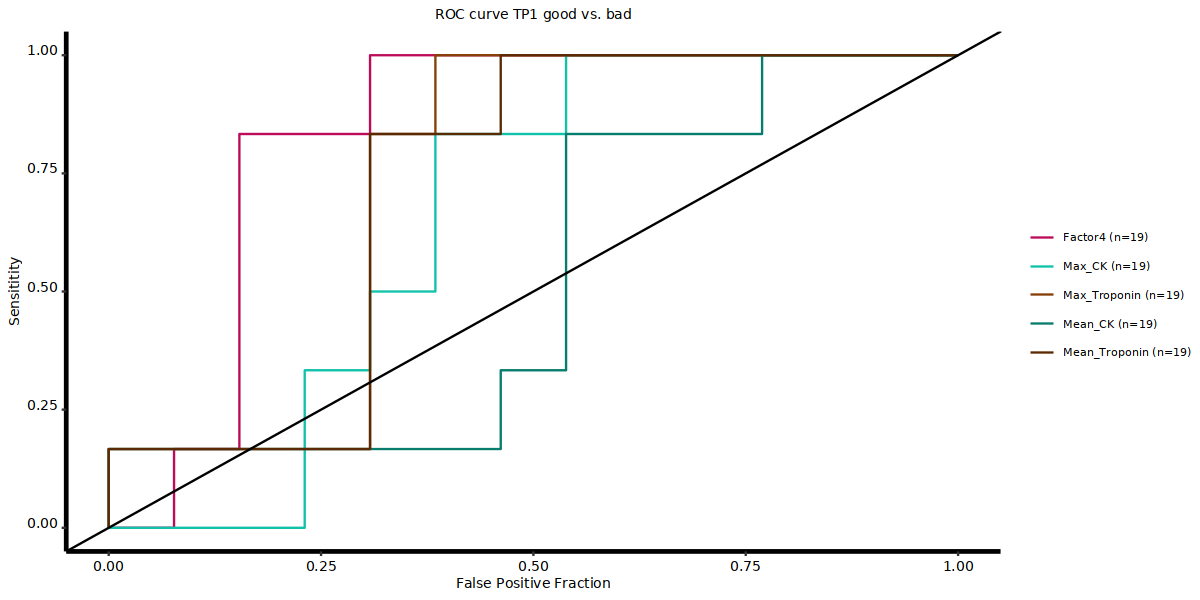

In [221]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle + 
     scale_color_manual(values = c('Factor4 (n=19)' = "#BC0B58",
                                      'Mean_CK (n=19)' = "#087C6D",
                                      'Max_CK (n=19)'="#11C1A9",
                                   'Max_Troponin (n=19)' = '#863F06',
                                   'Mean_Troponin (n=19)' = '#5B2A03'
                                     ))+
       scale_linetype_manual(values = c('Factor4 (n=19)' = "solid",
                                      'Mean_CK (n=19)' = "solid",
                                      'Max_CK (n=19)'="solid",
                                               'Max_Troponin (n=19)'="solid",
                                               'Mean_Troponin (n=19)'="solid"
                                     ))+
    ggtitle('ROC curve TP1 good vs. bad') +
    geom_abline(slope = 1, intercept = 0)

roc_plot

In [222]:
pdf(paste0('figures/Final_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


png 
  2

In [223]:
### Plot 2: all CRP Features (investigated during revision)

In [224]:
## Specify Plot // TEST prediction of CRP value (for reviewer question)
rocplot = ggplot(prediction_data_long[!is.na(str_extract(prediction_data_long$variable, 'CRP|Factor4')),], aes(m = value, d = as.numeric(y), color = variable_w_n))+ geom_roc(n.cuts=0,labels=FALSE, size = 0.5)

In [225]:
unique(prediction_data_long$variable)

[1] Factor4            Max_CK             Max_CRP            Max_Troponin      
[5] Mean_CK            Mean_Troponin      Normalized_CRP_TP1 Normalized_CRP_TP2
[9] Normalized_CRP_TP3
9 Levels: Factor4 Mean_CK Max_CK Mean_Troponin Max_Troponin ... Normalized_CRP_TP1

In [226]:
# Figure Name
figure_name = 'REV10_E9_ROC_CRP'

In [227]:
# Sizes of the plot
width_par = 4
height_par = 2

In [228]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity')

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


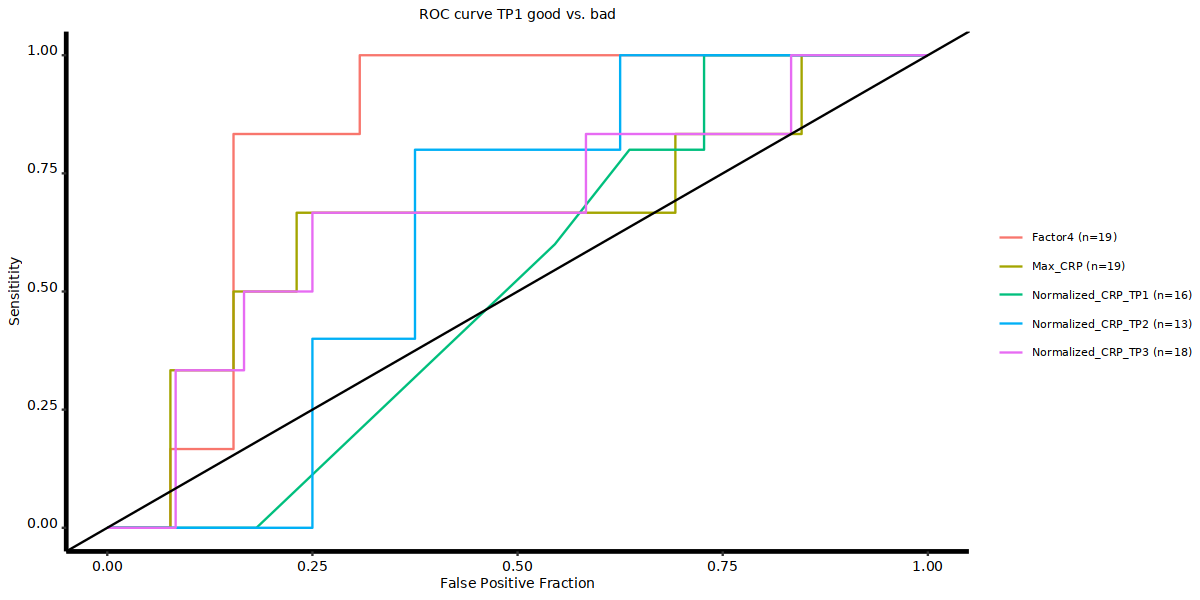

In [229]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle +                            
    ggtitle('ROC curve TP1 good vs. bad') +
    geom_abline(slope = 1, intercept = 0)
options(repr.plot.width=10, repr.plot.height=5)
roc_plot

In [230]:
pdf(paste0('figures/Review_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

Warning message:
“The following aesthetics were dropped during statistical transformation: m, d
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


png 
  2

## Calculate AUC values

In [231]:
auc_values = data.frame()

In [232]:
for(i in unique(prediction_data_long$variable)){
    calc_auc = data.frame(variable = i, 
                          auc = auc(prediction_data_long$y[prediction_data_long$variable == i], prediction_data_long$value[prediction_data_long$variable == i])
                          )
    auc_values = rbind(auc_values, calc_auc)
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [233]:
auc_values

variable,auc
<chr>,<auc>
Factor4,0.8333333
Max_CK,0.6538462
Max_CRP,0.6538462
Max_Troponin,0.7307692
Mean_CK,0.4743590
Mean_Troponin,0.7179487
Normalized_CRP_TP1,0.5181818
Normalized_CRP_TP2,0.6250000
Normalized_CRP_TP3,0.6666667


In [234]:
### Save AUC values

In [235]:
write.csv(auc_values, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_ROC_Plot_AUC_values_P2.csv'), row.names = FALSE)

## Prediction Metrics Table

In [237]:
head(prediction_data_long,2)

,variable,y,tp_outcome,value,n,variable_w_n
,<fct>,<chr>,<chr>,<dbl>,<int>,<chr>
1,Factor4,1,TP1_bad,0.4734997,19,Factor4 (n=19)
2,Factor4,1,TP1_bad,0.8558891,19,Factor4 (n=19)


In [238]:
prediction_data_long$y = as.factor(prediction_data_long$y)

In [239]:
levels(prediction_data_long$y)

[1] "0" "1"

In [240]:
prediction_data_long$y = relevel(prediction_data_long$y, '0')

In [241]:
TP_prediction_metrics = data.frame()

In [242]:
for(i in unique(prediction_data_long$variable)){
    data_use = prediction_data_long[prediction_data_long$variable == i,]
    metrics = measureit(score =  data_use$value, class =  data_use$y, measure = c( 'PREC', 'REC', 'SPEC', 'FPR'))
    metrics = data.frame(do.call(cbind, metrics))
    metrics$model = i
    
    TP_prediction_metrics = rbind( metrics, TP_prediction_metrics)
    }

In [243]:
head(TP_prediction_metrics,2)

,Cutoff,Depth,TP,FP,TN,FN,SPEC,PREC,REC,FPR,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Inf,0.00000000,0,0,12,6,1.0000000,NaN,0,0.00000000,Normalized_CRP_TP3
2,1,0.05555556,0,1,11,6,0.9166667,0,0,0.08333333,Normalized_CRP_TP3


In [244]:
unique(TP_prediction_metrics$model)

[1] "Normalized_CRP_TP3" "Normalized_CRP_TP2" "Normalized_CRP_TP1"
[4] "Mean_Troponin"      "Mean_CK"            "Max_Troponin"      
[7] "Max_CRP"            "Max_CK"             "Factor4"

In [245]:
### Save as supplementary table

In [246]:
write.csv(TP_prediction_metrics, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_prediction_metrics_P2.csv'), row.names = FALSE)